In [1]:
import numpy as np
from spectral_cube import SpectralCube
from astropy.io import fits
from reproject import reproject_interp
from tqdm.auto import tqdm
import pyspeckit
from astropy.table import Table, hstack, join
from astropy import stats
import os
import astropy.units as u
import astropy.constants as c
from radio_beam import Beam

import warnings
warnings.filterwarnings('ignore')

In [128]:
def get_meerkat_FluxAlpha(hdu_regrid, hdu_alpha_regrid, index_map_hdu):
    
    index_map = index_map_hdu.data.copy()
    index_map[index_map==0] = np.nan
    index_map_is_dust = np.ones(index_map.shape) *np.nan
    
    beam = Beam.from_fits_header(hdu_regrid.header) 
    pixel_area = (hdu_regrid.header['CDELT1']*u.deg)**2
    beam_area = beam.sr
    ratio_area = pixel_area.to('sr')/beam_area.to('sr')
    
    # Load the data cube
    unique_indexes = np.unique(index_map)
    
    stats_id = np.ones(len(unique_indexes)) *np.nan
    stats_flux = np.ones(len(unique_indexes)) *np.nan 
    stats_alpha = np.ones(len(unique_indexes)) *np.nan 
    is_dust = np.array([False]*len(unique_indexes))
    
    i = 0
    for index in tqdm(unique_indexes):
        
        # Radio sources cores 
        # if index not in [1482, 1179, 1214, 3204, 3758]: 
        #     continue
            
        # Dust cores 
        if index not in [4251, 4257, 582, 756, 55, 3356, 3047, 3099]: 
            continue
        
        # Create a mask for the current index
        mask = (index_map == index)
        
        masked_data = hdu_regrid.data[mask]
        masked_alpha_data = hdu_alpha_regrid.data[mask]
        
        stats_id[i] = index
        stats_flux[i] = np.nansum(masked_data)*ratio_area
        stats_alpha[i] = np.nanmean(masked_alpha_data)
        
        i+=1
    
    return (stats_id, stats_flux*u.Jy, stats_alpha)

In [129]:
# Define files 
index_map_filename = "/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m_cont/ACES_leaf_mask_3_1_mp179_pb0.55_pp6_pm2_ar3.0_sm25.fits"
catalog_filename = '/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m_cont/aces_catalog_3_1_mp179_pb0.55_pp6_pm2_ar3.0_sm25.fits'

meerkat_filename = '/Users/abarnes/Dropbox/work/Smallprojects/aces/data/misc/regrid/MeerKAT_Galactic_Centre_1284MHz-StokesI.fits'
meerkat_alpha_filename = '/Users/abarnes/Dropbox/work/Smallprojects/aces/data/misc/regrid/MeerKAT_Galactic_Centre_alpha.fits'

In [130]:
#Load catalog 
catalog = Table.read(catalog_filename)

In [131]:
#Open index map 
index_map_hdu = fits.open(index_map_filename)[0]

#Open Meerkat image
meerkat_hdu = fits.open(meerkat_filename)[0]
meerkat_alpha_hdu = fits.open(meerkat_alpha_filename)[0]

In [132]:
if not os.path.exists('./tmp/meerkat_hdu_regrid.fits'):
    print('[INFO] Making Meerkat regrid...')
    
    header = index_map_hdu.header.copy()
    header['BUNIT'] = meerkat_hdu.header['BUNIT']
    header['BMAJ'] = meerkat_hdu.header['BMAJ']
    header['BMIN'] = meerkat_hdu.header['BMIN']
    header['BPA'] = meerkat_hdu.header['BPA']
    
    meerkat_data_regrid, _ = reproject_interp(meerkat_hdu, header, parallel=True)
    meerkat_hdu_regrid = fits.PrimaryHDU(meerkat_data_regrid, header)
    meerkat_hdu_regrid.writeto('./tmp/meerkat_hdu_regrid.fits', overwrite=True)
else:
    print('[INFO] Loading Meerkat regrid...')
    meerkat_hdu_regrid = fits.open('./tmp/meerkat_hdu_regrid.fits')[0]
    
if not os.path.exists('./tmp/meerkat_alpha_hdu_regrid.fits'):
    print('[INFO] Making Meerkat regrid...')
    meerkat_data_regrid, _ = reproject_interp(meerkat_alpha_hdu, index_map_hdu.header, parallel=True)
    meerkat_alpha_hdu_regrid = fits.PrimaryHDU(meerkat_data_regrid, index_map_hdu.header)
    meerkat_alpha_hdu_regrid.writeto('./tmp/meerkat_alpha_hdu_regrid.fits')
else:
    print('[INFO] Loading Meerkat regrid...')
    meerkat_alpha_hdu_regrid = fits.open('./tmp/meerkat_alpha_hdu_regrid.fits')[0]

[INFO] Loading Meerkat regrid...
[INFO] Loading Meerkat regrid...


In [133]:
#Get Meerkat stats
stats_out = get_meerkat_FluxAlpha(meerkat_hdu_regrid, meerkat_alpha_hdu_regrid, index_map_hdu)

  0%|          | 0/690 [00:00<?, ?it/s]

In [134]:
#Make table
catalog_meerkat = Table(stats_out, names=['index', 'flux_meerkat', 'alpha_meerkat'])
catalog_all = join(catalog, catalog_meerkat)

#Save catalog
catalog_all.write(catalog_filename.replace('.fits', '_meerkat.fits'), overwrite=True)

In [135]:
catalog_all

index,area_ellipse,area_exact,flux_integrated,major_sigma,minor_sigma,position_angle,radius,RA,Dec,is_leaf,peak_cont_flux,min_cont_flux,mean_cont_flux,npix,noise,axis_ratio,mass,eff_radius,flux_meerkat,alpha_meerkat
,arcsec2,arcsec2,Jy,arcsec,arcsec,deg,arcsec,,,,,,,,,arcsec,,,Jy,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
582.0,9.523721619989836,29.47999998667504,0.0018110214332865099,1.7238516207156673,1.2685537552002828,163.06440217178218,1.4787827585101718,0.09999405901221457,-0.10365391846519031,True,0.0007640950301907119,0.0003006532256917076,0.0004405695549572809,737,9.745041550055535e-05,1.3589109753125919,50.14922132376147,3.06329486671732,0.007862796742738857,-0.291840320120286
756.0,13.772888819106354,43.5999999802928,0.002649109919104649,2.9562367786884165,1.069763781904021,115.09935568793487,1.7783349056275877,0.5444121673791815,-0.08853506290772652,True,0.0007216969819969068,0.0003000247474031156,0.00043574444666369193,1090,0.00010348294291583396,2.7634481823891557,73.3568345478181,3.725360523672881,0.007360650871539555,-0.25070799938727173
3047.0,3.1475603550667777,9.51999999569696,0.00122270437102421,1.036924579830509,0.6969938748222952,-142.55139184137477,0.8501353308706484,0.08010289898529233,-0.00996256266306254,True,0.0011326789531950474,0.0007635642225794617,0.0009210917401841813,238,0.00015723006539593694,1.4877097450747068,33.85805987107995,1.740778594508787,0.0022143932540636736,-0.4685670843126224
3099.0,6.692001975377004,19.159999991339678,0.0011384739146152881,1.791302892937174,0.8578060354201614,120.26211581961059,1.239592849619222,0.6457195132906378,-0.006419707206249819,True,0.0005707795005470446,0.00030446199452036386,0.00042613376870136854,479,8.933274495520564e-05,2.088237688908049,31.52562375353114,2.469578388414663,0.0007325766654626765,-0.7895463111064489
3356.0,42.045996030486336,119.5999999459408,0.009734477120405337,4.6272043790533175,2.0864502179499507,159.7551833857442,3.1071581204011425,0.5308288644593311,0.004550632013853534,True,0.0010610926098133804,0.0003431917303133518,0.0005837136112885181,2990,0.00010486977289676035,2.217740130699018,269.5586250994238,6.170077987381828,0.0020890738226875334,-0.28499382272368406
4251.0,2.4740446433112493,7.95999999640208,0.00047032793879337603,0.8372241486260681,0.6785281188081298,108.45407862762174,0.753710903853715,359.9848101537182,0.03926898922000747,True,0.000585846296955018,0.00030013049787354617,0.00042374645845528683,199,9.723690966302426e-05,1.233882760963092,13.023909857595857,1.591774699157428,0.003999746294569936,-0.7189719952442643
4257.0,13.098329033400352,38.63999998253472,0.0064213779438242686,2.505690325855785,1.2003020945140856,142.81154521771393,1.734239126051647,0.11598629402451727,0.03982789767176326,True,0.0019081375394151144,0.0009366667724603524,0.0011918167525000432,966,0.00019134896042546297,2.0875497404427636,177.81518086396815,3.5070634434783616,0.0023450470068936418,-0.7033920916421236


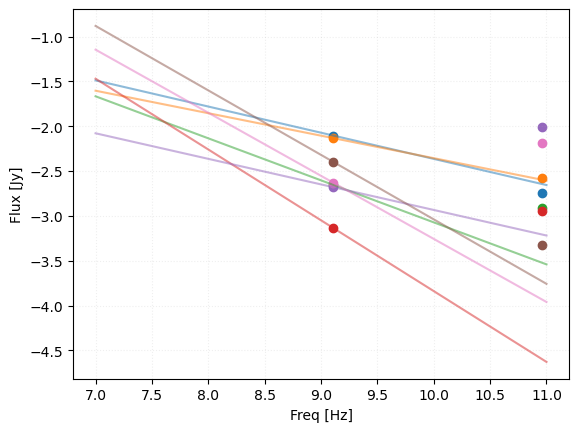

In [136]:
import matplotlib.pyplot as plt

def plot_line(a, flux, freq, x_range=(7, 11)):
    """
    Plot the line y = ax + b.

    Parameters:
    - a (float): Slope of the line.
    - b (float): Y-intercept of the line.
    - x_range (tuple): Range of x values to plot.
    """
    # Generate x values
    x = np.linspace(x_range[0], x_range[1], 10)
    
    b = flux - (a*freq)
    
    # Calculate y values
    y = a * x + b

    # Plotting
    plt.plot(x, y, label=f"y = {a}x + {b}", ls='-', alpha=0.5)
    

freq_meerkat = np.log10(1.2839e9)
freq_alma = np.log10(9.15E+10)

for i in range(len(catalog_all)):

    flux_meerkat = np.log10(catalog_all['flux_meerkat']).value[i]
    flux_alma = np.log10(catalog_all['flux_integrated']).value[i]
    alpha_meerkat = catalog_all['alpha_meerkat'].value[i]

    plot_line(alpha_meerkat, flux_meerkat, freq_meerkat)
    plt.scatter([freq_meerkat,freq_alma], [flux_meerkat,flux_alma])

plt.xlabel("Freq [Hz]")
plt.ylabel("Flux [Jy]")
plt.grid(ls=':', alpha=0.2)
plt.show()